# Import Basic Libraries

In [9]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Data Exploration
## HDBdata was obtained from https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view

In [10]:
# Assign data file to a variable

file = "ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv"

# Create a Data Frame 

hdb_df = pd.read_csv(file)
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [11]:
# Create a temporary Data Frame to view unique values for relevant categorical columns

temp_df = hdb_df.drop(['month','block','street_name','floor_area_sqm','lease_commence_date',
                   'remaining_lease','resale_price'],axis = 1)

for i in temp_df:
    print(i,':')
    print(temp_df[i].unique())
    print(' ')

town :
['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TOA PAYOH' 'WOODLANDS' 'YISHUN']
 
flat_type :
['2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE' '1 ROOM'
 'MULTI-GENERATION']
 
storey_range :
['10 TO 12' '01 TO 03' '04 TO 06' '07 TO 09' '13 TO 15' '19 TO 21'
 '22 TO 24' '16 TO 18' '34 TO 36' '28 TO 30' '37 TO 39' '49 TO 51'
 '25 TO 27' '40 TO 42' '31 TO 33' '46 TO 48' '43 TO 45']
 
flat_model :
['Improved' 'New Generation' 'DBSS' 'Standard' 'Apartment' 'Simplified'
 'Model A' 'Premium Apartment' 'Adjoined flat' 'Model A-Maisonette'
 'Maisonette' 'Type S1' 'Type S2' 'Model A2' 'Terrace'
 'Improved-Maisonette' 'Premium Maisonette' 'Multi Generation'
 'Premium Apartment Loft' '2-room' '3Gen']
 


In [12]:
# Check for any missing data

hdb_df.isnull().sum() 

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [13]:
# View data types of each column

hdb_df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

# Data Cleaning

In [14]:
# 1)Creating 2 new columns ('years' and 'months').
# 2)Extract substrings using a regular expression pattern.
# 3)'\d+' Shorthand character class that matches any digit (0-9), one of more times consecutively.
# 4)"years" year followed by an optional "s", allowing both 'year' and 'years' to match.
# 5)Converts extracted values to float.

hdb_df['years'] = hdb_df['remaining_lease'].str.extract(r'(\d+) years?').astype(float) 
hdb_df['months'] = hdb_df['remaining_lease'].str.extract(r'(\d+) months?').astype(float)

# Fills missing values in the 'months' column with 0 using fillna(0, inplace=True)

hdb_df['months'].fillna(0, inplace=True)

# Convert to numerical representation (total months)

hdb_df['remaining_lease_months'] = hdb_df['years'] * 12 + hdb_df['months']

# Clean Storey (e.g. if storey_range = 10 TO 12, storey = 11)

hdb_df[['start', 'end']] = hdb_df['storey_range'].str.split(' TO ', expand=True).astype(int)
hdb_df['storey'] = (hdb_df['start'] + hdb_df['end']) / 2

# Drop irrelevant columns

hdb_df = hdb_df.drop(['month', 'street_name', 'block', 'years', 'months', 
                      'remaining_lease', 'lease_commence_date', 'start','end'], axis=1)

# Check for any missing data again
hdb_df.isnull().sum()

town                      0
flat_type                 0
storey_range              0
floor_area_sqm            0
flat_model                0
resale_price              0
remaining_lease_months    0
storey                    0
dtype: int64

In [15]:
# Preview cleaned data

hdb_df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,remaining_lease_months,storey
0,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,232000.0,736.0,11.0
1,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,250000.0,727.0,2.0
2,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,262000.0,749.0,2.0
3,ANG MO KIO,3 ROOM,04 TO 06,68.0,New Generation,265000.0,745.0,5.0
4,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,265000.0,749.0,2.0


## Determining Correlations

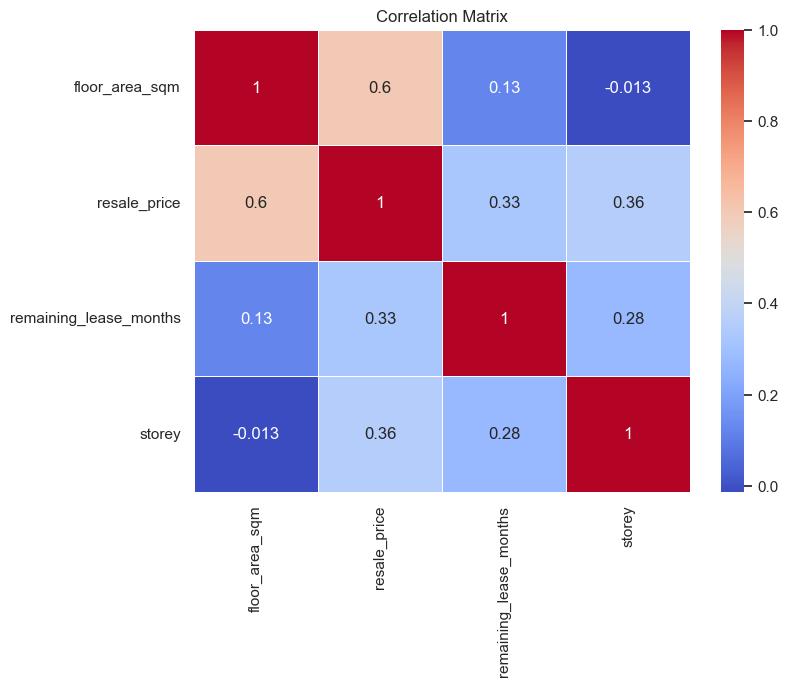

In [16]:
# Create a new Data Frame only consisting of 'float' data types

numeric_df = hdb_df.select_dtypes(include=['float'])

# Create correlation heat map

correlation_matrix = numeric_df.corr()

# Plotting

plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# Bivariate Prediction
## Since Floor Area Sqm has the highest correlation with Resale Price (0.6), we decide to perform further analysis
## First, removing outliers, followed by creating a linear regression model to see if Floor Area Sqm can be used to predict the Resale Price

Use IQR if:

Your dataset is relatively small.
The distribution of your data is approximately Gaussian or symmetric.
Prefer a simple and computationally efficient method.

Use LOF if:

Your dataset has a complex distribution or contains clusters of different densities.
You have a larger dataset or high-dimensional data.
You need a method that is more robust to outliers and can handle non-Gaussian distributions.

# Anomaly Detection

In [17]:
# Import LocalOutlierFactor from sklearn.neighbors
from sklearn.neighbors import LocalOutlierFactor

In [18]:
# Create a Data Frame with only Floor Area Sqm and Resale Price

fsqm_price_df = pd.DataFrame(hdb_df[["floor_area_sqm", "resale_price"]])

# Set the Parameters for Neighborhood

num_neighbors = 20      # Number of Neighbors
cont_fraction = 0.1    # Fraction of Anomalies

# Create Anomaly Detection Model using LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors = num_neighbors, contamination = cont_fraction)

# Fit the Model on the Data and Predict Anomalies
lof.fit(fsqm_price_df)

LocalOutlierFactor(contamination=0.1)

<Axes: xlabel='Anomaly', ylabel='count'>

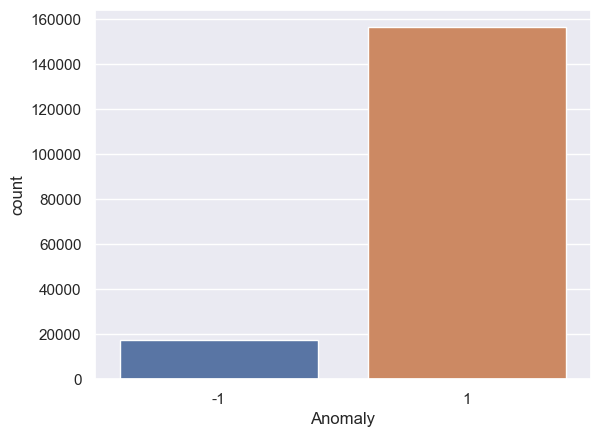

In [19]:
# Predict the Anomalies

labels = lof.fit_predict(fsqm_price_df)

# Append Labels to the Data

A_labeled = fsqm_price_df.copy()
A_labeled["Anomaly"] = pd.Categorical(labels)

# Summary of the Anomaly Labels

sb.countplot(x="Anomaly",data=A_labeled)

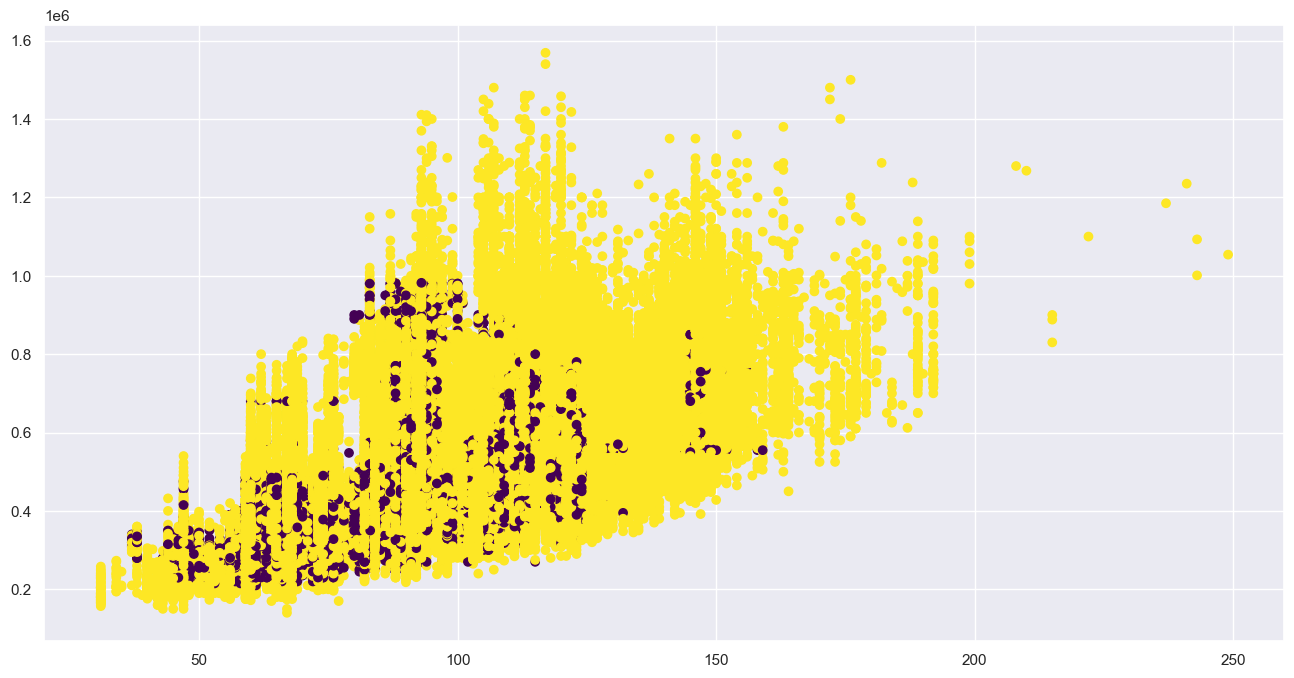

In [20]:
# Visualize Anomalies

f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "floor_area_sqm", y = "resale_price", c = "Anomaly", cmap = 'viridis', data = A_labeled)

In [21]:
# Create variable for outliers

outlier_indices = np.where(labels == -1)[0]

# Remove outliers from the dataset

fsqm_price_clean_df = A_labeled.drop(index=outlier_indices)

# Check if any changes from cleaning

print("Total number of rows (Before):", len(fsqm_price_df))
print("Total number of rows (After):", len(fsqm_price_clean_df))


Total number of rows (Before): 173681
Total number of rows (After): 156395


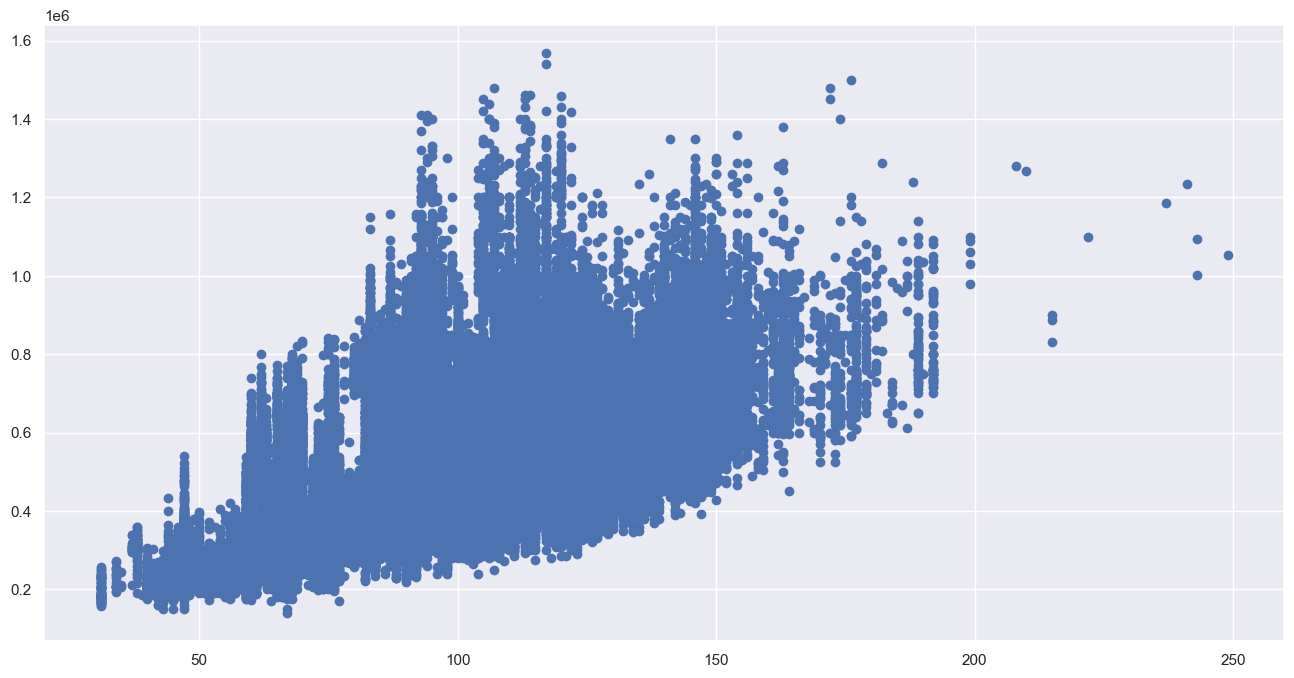

In [22]:
# Visualize Resale Price against Floor Area Sqm

f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "floor_area_sqm", y = "resale_price", data = fsqm_price_clean_df)

# Linear Regression Model

In [23]:
# Import required libraries

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

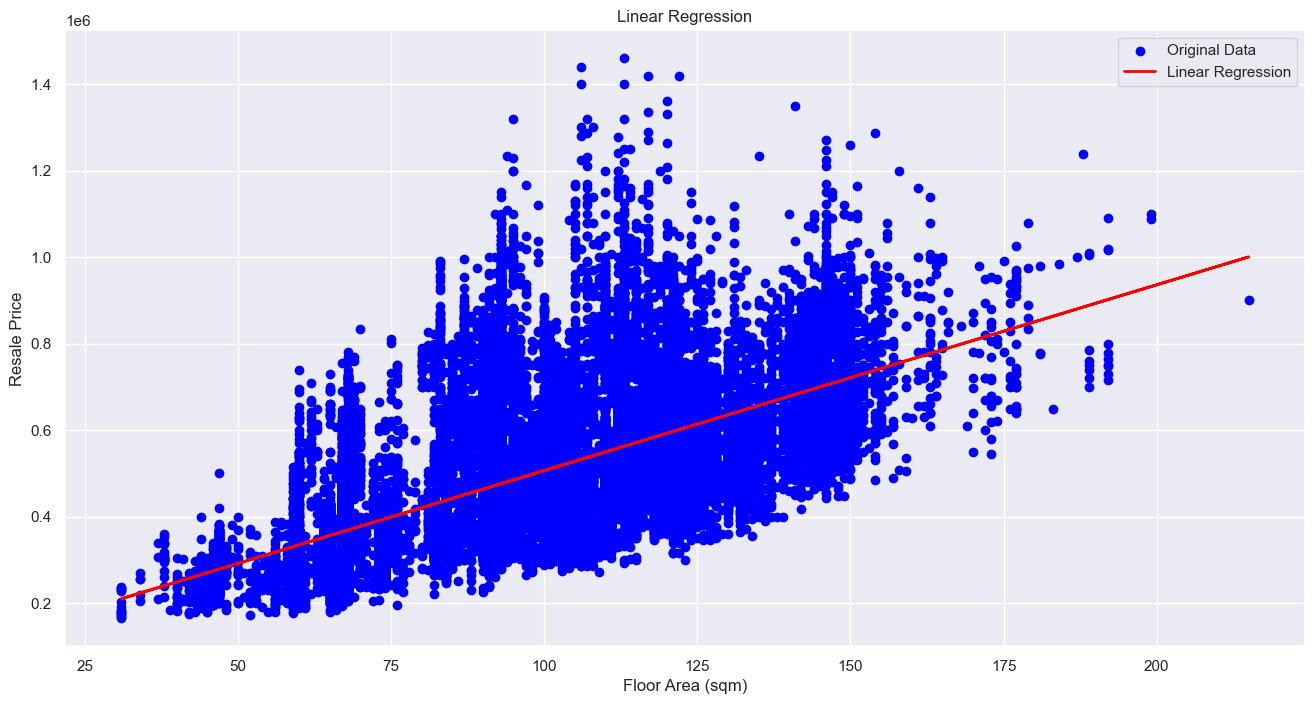

In [24]:
# Predictor -> Floor Area Sqm
# Response  -> Resale Price

# Random Split of train and test data set, test size = 0.2

x = fsqm_price_clean_df[['floor_area_sqm']] 
y = fsqm_price_clean_df['resale_price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a linear regression model

linreg = LinearRegression()

# Train the model on the training data

linreg.fit(x_train, y_train)

# Make predictions using test data

y_pred = linreg.predict(x_test)

# Plot of original data and regression line

plt.figure(figsize=(16, 8))
plt.scatter(x_test, y_test, color='blue', label='Original Data')
plt.plot(x_test, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')
plt.title('Linear Regression')
plt.legend()

In [25]:
#y = m(Floor_sqm)+C

print("Intercept:", linreg.intercept_)
print("Gradient:", linreg.coef_[0])

Intercept: 76948.84854408854
Gradient: 4295.992205976229


In [26]:
# Determining how well the data fits the regression model

r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

R-squared: 0.36900724688791087


## Are there trends that can be observed between Resale Price and Town?

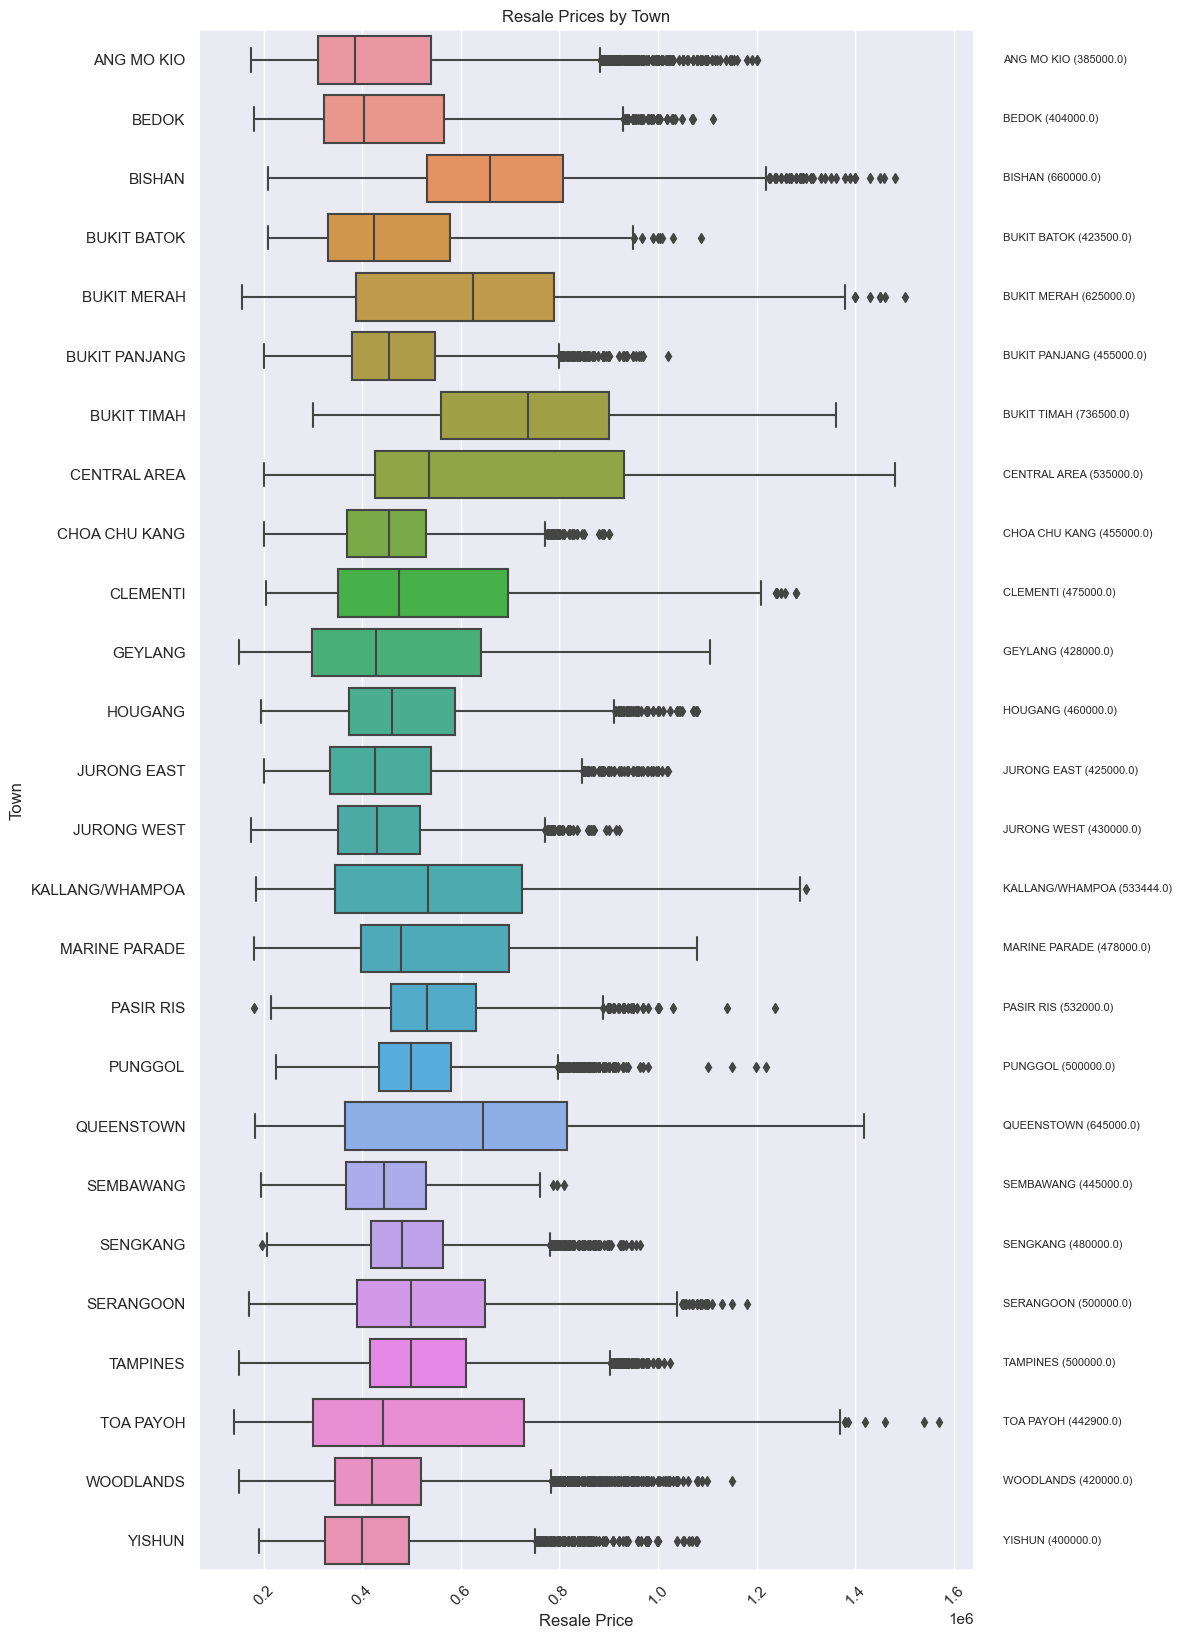

In [27]:
# Create a Data Frame with only Town and Resale Price 

town_price_df = pd.DataFrame(hdb_df[['town', 'resale_price']])

# Create a Data Frame with only Flat Type and Resale Price (For later use)

flat_resale = pd.DataFrame(hdb_df[['flat_type', 'resale_price']])

# Create box plot of Resale Prices of each Town

plt.figure(figsize = (10, 20))
sb.boxplot(x = 'resale_price', y = 'town', data = town_price_df)
plt.title('Resale Prices by Town')
plt.xlabel('Resale Price')
plt.ylabel('Town')
plt.xticks(rotation = 45)

# Create a Data Frame for the median price of each town

median_prices = town_price_df.groupby('town')['resale_price'].median().reset_index()

# Styling (insert median price on the right)

for index, row in median_prices.iterrows():
    plt.text(1700000, index, f'{row["town"]} ({row["resale_price"]})', fontsize=8, va='center')

plt.show()

## Multi-Variate Prediction 

In [28]:
# Import required libraries

#MinMaxScaler standardizes features by scaling to a given range; brings the numerical values to a uniform scale 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [29]:
hdb_df.dtypes

town                       object
flat_type                  object
storey_range               object
floor_area_sqm            float64
flat_model                 object
resale_price              float64
remaining_lease_months    float64
storey                    float64
dtype: object

In [30]:
# Remove previously created 'storey' column

hdb_df = hdb_df.drop(columns=['storey'])

### pd.get_dummies is a way to represent categorical variables as binary vectors, where each category becomes a separate column, and a value of 1 or 0 indicates a True or False value of that category for each observation.

In [31]:
hdb_df = pd.get_dummies(hdb_df,columns=["town", "flat_type", "flat_model", "storey_range"], dtype = 'int')
hdb_df.head()

,floor_area_sqm,resale_price,remaining_lease_months,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,storey_range_22 TO 24,storey_range_25 TO 27,storey_range_28 TO 30,storey_range_31 TO 33,storey_range_34 TO 36,storey_range_37 TO 39,storey_range_40 TO 42,storey_range_43 TO 45,storey_range_46 TO 48,storey_range_49 TO 51
0,44.0,232000.0,736.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67.0,250000.0,727.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67.0,262000.0,749.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,265000.0,745.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67.0,265000.0,749.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Prepare x and y data for linear regression model
# y = Resale Price
# x = All other features

y = hdb_df['resale_price']
x = hdb_df.drop(columns=['resale_price'])
x.head()

,floor_area_sqm,remaining_lease_months,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,...,storey_range_22 TO 24,storey_range_25 TO 27,storey_range_28 TO 30,storey_range_31 TO 33,storey_range_34 TO 36,storey_range_37 TO 39,storey_range_40 TO 42,storey_range_43 TO 45,storey_range_46 TO 48,storey_range_49 TO 51
0,44.0,736.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67.0,727.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67.0,749.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,745.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67.0,749.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Split train and test, Supervised learning
# 70% training data and 30% test data
# Setting random states to a specific values ensures that the random splitting is reproducible

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 2)

# Normalisation, scaling and transforming the features of a dataset to a standard range

scaler_x = MinMaxScaler(feature_range=(0,1))
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
x_train_scaled.shape

(121576, 73)

## Multiple Linear Regression Line

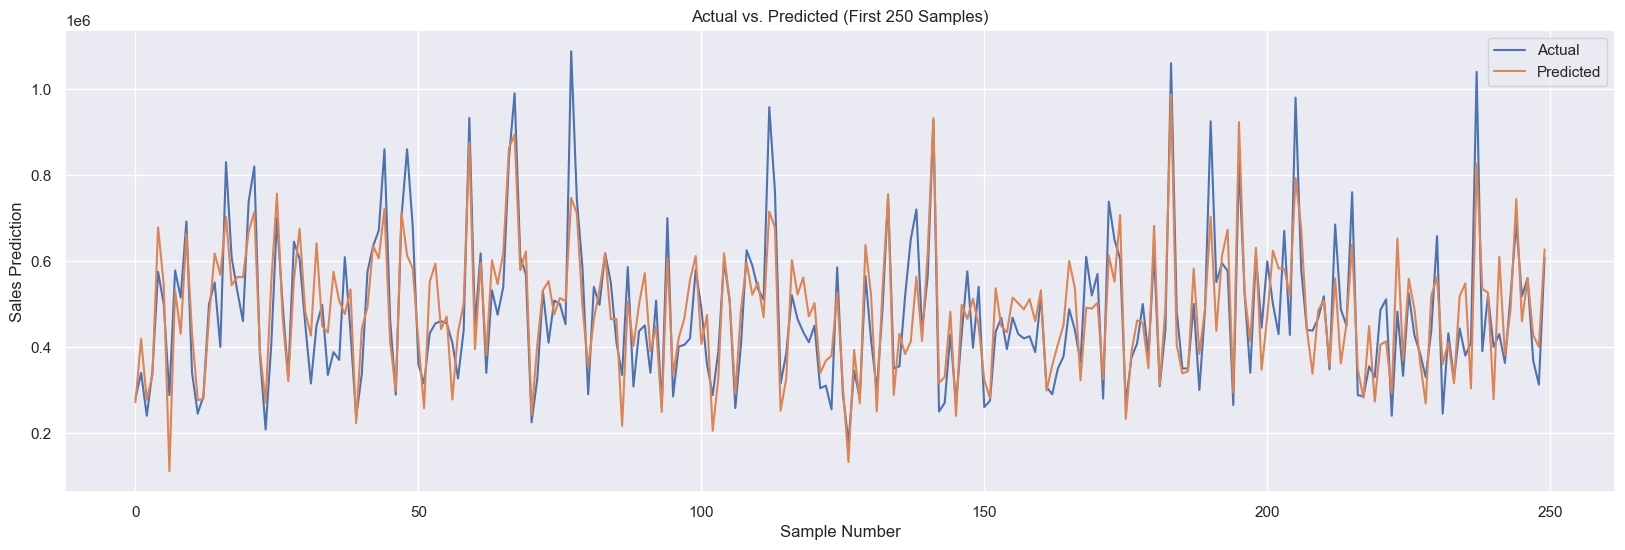

In [34]:
# Create a multiple linear regression model

lin_reg = LinearRegression()

# Train the model on the training data

lin_reg.fit(x_train_scaled, y_train)

# Compute predictions from the test set

y_pred = lin_reg.predict(x_test_scaled)

# Create a plot to visualize actual vs predicted Resale Price (first 250 samples)

plt.figure(figsize=(20, 6))

# Create an array of sample indices for the x-axis
sample_indices = range(250)

# Slice the actual and predicted values to include only the first 500 samples
y_test_slice = y_test[:250]
y_pred_slice = y_pred[:250]

# Plot the actual values
plt.plot(sample_indices, y_test_slice, label="Actual", linestyle='-')

# Plot the predicted values
plt.plot(sample_indices, y_pred_slice, label="Predicted", linestyle='-')

#Label plot
plt.ylabel('Sales Prediction')
plt.xlabel('Sample Number')
plt.title('Actual vs. Predicted (First 250 Samples)')
plt.legend()
plt.grid(True)
plt.show()

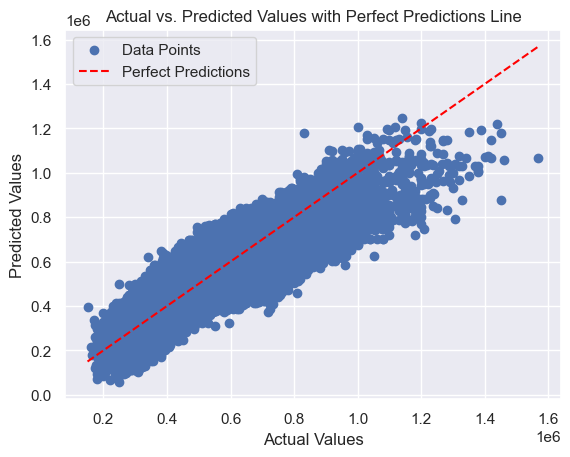

R^2: 0.7518347088970906
Mean Squared Error: 7218705480.951727
Root Mean Square Error: 84962.96534933163
Mean Absolute Error: 68766.49531139046


In [35]:
# Visualize predicted vs actual Resale Price

plt.scatter(y_test, y_pred, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', 
         linestyle='--', label='Perfect Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Perfect Predictions Line')
plt.legend()
plt.show()

# Create variables for R2 value, mean squared error, root mean squared error and
# mean absolute error, based on test data

r_squared = lin_reg.score(x_test_scaled, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print('R^2:', r_squared)
print('Mean Squared Error:', mse)
print('Root Mean Square Error:', rmse)
print('Mean Absolute Error:', mae)

# Error Analysis
### This section aims to identify common features of the data sets with the highest absolute error between the actual and predicted Resale Price, if any

In [36]:
# Create a variable of the absolute error between each predicted and actual Resale Price

absolute_error = abs(y_test - y_pred)

# Convert to it to a Data Frame

absolute_error_df = pd.DataFrame(absolute_error)

# Determine data sets with the top 100 largest absolute error

top_absolute_error = absolute_error_df.nlargest(100,'resale_price')

# Create a new Data Frame consisting of the top 100 data sets

# First, identify the index
top_indices = top_absolute_error.index

# Next, locate the index in the original data frame, and assign it to a new data frame
top_absolute_error_df = hdb_df.loc[hdb_df.index.isin(top_indices)] 

# Drop irrelevant columns
top_absolute_error_df = top_absolute_error_df.drop(['floor_area_sqm','resale_price',
                                                    'remaining_lease_months'], axis = 1)

top_absolute_error_df.head()

,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,...,storey_range_22 TO 24,storey_range_25 TO 27,storey_range_28 TO 30,storey_range_31 TO 33,storey_range_34 TO 36,storey_range_37 TO 39,storey_range_40 TO 42,storey_range_43 TO 45,storey_range_46 TO 48,storey_range_49 TO 51
8868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73367,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92129,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
118584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125934,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
# Create an empty dictionary to store counts
feature_counts = {}

# Iterate through each row
for index, row in top_absolute_error_df.iterrows():
  # Find non-zero columns using boolean indexing
  non_zero_cols = row.ne(0).values  # 'ne' stands for not equal
  # Get column names based on boolean indexing
  column_names = top_absolute_error_df.columns[non_zero_cols]

  # Update feature counts in the dictionary
  for col in column_names:
    if col not in feature_counts:
        feature_counts[col] = 0
    feature_counts[col] += 1

# Create a DataFrame from the dictionary
df_counts = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count'])
df_counts = df_counts.sort_values(by='count', ascending=False)

# Print the DataFrame with feature names and counts
df_counts


,count
flat_type_5 ROOM,58
flat_model_Improved,39
flat_type_EXECUTIVE,23
town_BUKIT MERAH,21
storey_range_13 TO 15,17
storey_range_07 TO 09,14
flat_type_4 ROOM,14
storey_range_10 TO 12,13
town_ANG MO KIO,13
storey_range_04 TO 06,12


### It can be observed that there may common features between the top data sets with the largest absolute errors

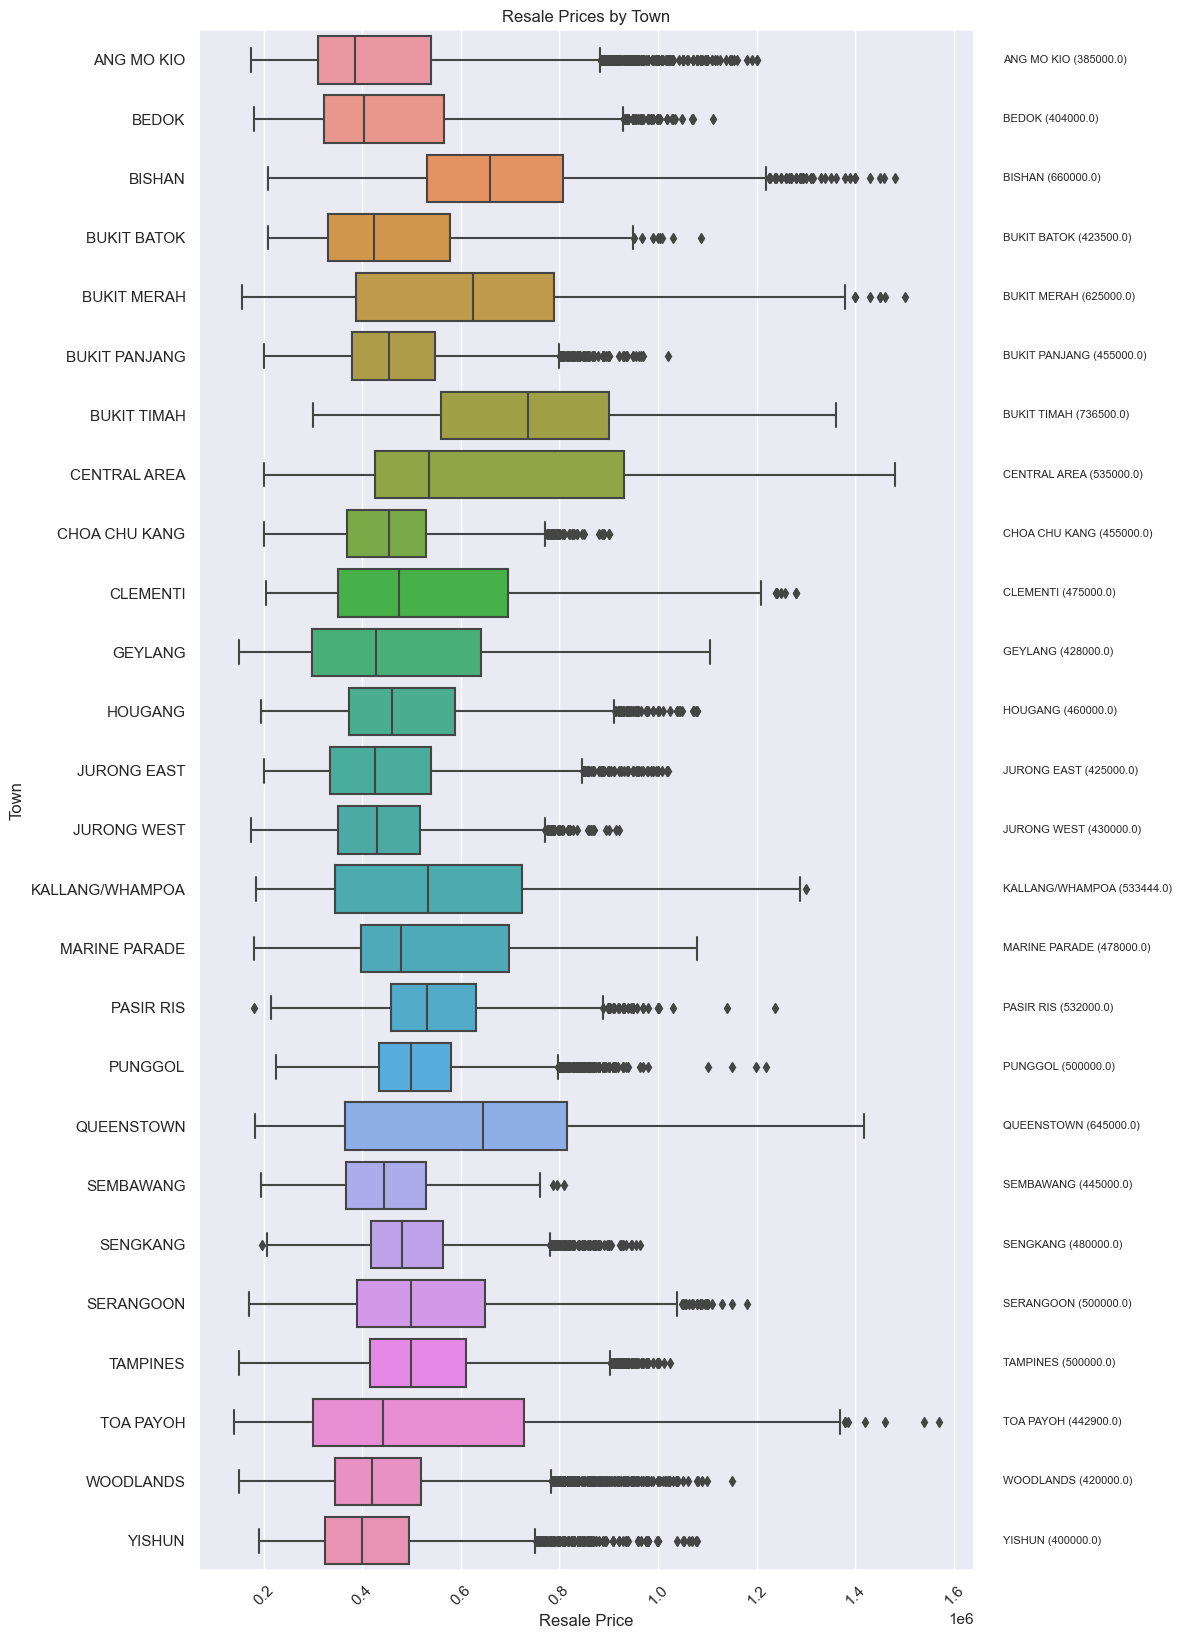

In [38]:

# Create box plot of Resale Prices of each Town

plt.figure(figsize = (10, 20))
sb.boxplot(x = 'resale_price', y = 'town', data = town_price_df)
plt.title('Resale Prices by Town')
plt.xlabel('Resale Price')
plt.ylabel('Town')
plt.xticks(rotation = 45)

# Create a Data Frame for the median price of each town

median_prices = town_price_df.groupby('town')['resale_price'].median().reset_index()

# Styling (insert median price on the right)

for index, row in median_prices.iterrows():
    plt.text(1700000, index, f'{row["town"]} ({row["resale_price"]})', fontsize=8, va='center')

plt.show()

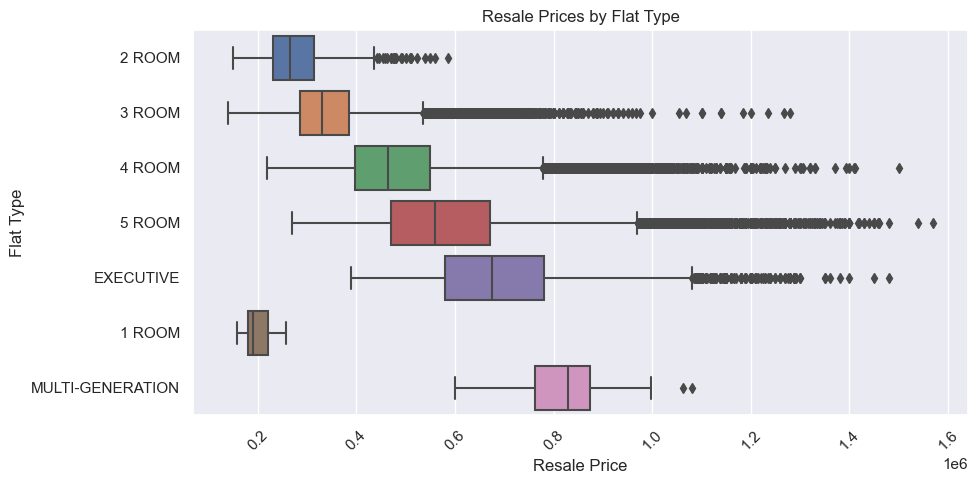

In [39]:
# # Create box plot of Resale Prices of each Flat Type

plt.figure(figsize=(10, 5))
sb.boxplot(x='resale_price', y='flat_type', data=flat_resale)
plt.title('Resale Prices by Flat Type')
plt.xlabel('Resale Price')
plt.ylabel('Flat Type')
plt.xticks(rotation=45)

median_prices_flattypes = flat_resale.groupby('flat_type')['resale_price'].median().reset_index()


plt.show()

# Additional Info: Random Forest
### In this section, random forest machine learning algorithm was explored, to determine if it will be a better model for predicting Resale Price

In [40]:
# Import required libraries

from sklearn.ensemble import RandomForestRegressor

In [41]:
# Split the test and training data set

train = hdb_df.sample(frac=0.7, random_state=101)
test = hdb_df.drop(train.index)

# Set x and y variables for test and train data
# y = Resale Price
# x = All other features

trainY = train["resale_price"]
trainX = train.drop(columns=["resale_price"])


testY = test["resale_price"]
testX = test.drop(columns=["resale_price"])

# Create a regression model

model = RandomForestRegressor(random_state=42).fit(trainX,trainY)


# Compute predictions

predY = model.predict(testX)

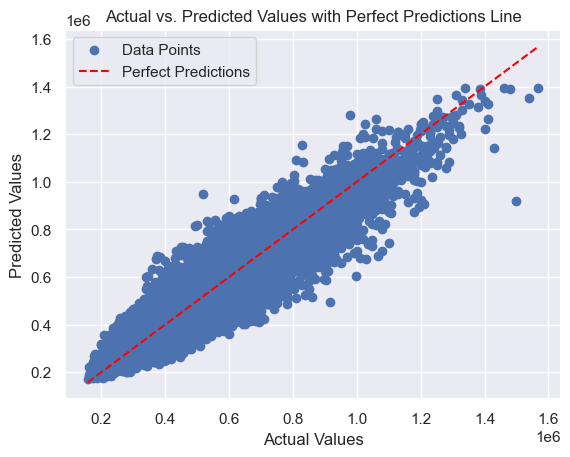

R^2: 0.7500280667232998
Mean Squared Error: 2826870268.803639
Root Mean Square Error: 53168.320161574025
Mean Absolute Error: 37285.01228796301


In [42]:
# Determine relevant information (same as previous)
# Visualize predicted vs actual Resale Price


plt.scatter(testY, predY, label='Data Points')
plt.plot([min(testY), max(testY)], [min(testY), max(testY)], color='red', 
         linestyle='--', label='Perfect Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Perfect Predictions Line')
plt.legend()
plt.show()

# Scaling x dataset

testX_scaled = scaler_x.transform(testX)

# Create variables for R2 value, mean squared error, root mean squared error and
# mean absolute error, based on test data

r_squared_rf = lin_reg.score(testX_scaled, testY)
mse_rf = mean_squared_error(testY, predY)
rmse_rf = np.sqrt(mean_squared_error(testY, predY))
mae_rf = mean_absolute_error(testY, predY)

print('R^2:', r_squared_rf)
print('Mean Squared Error:', mse_rf)
print('Root Mean Square Error:', rmse_rf)
print('Mean Absolute Error:', mae_rf)

### It is noted that although R^2 did not change much, RMSE decreased by about 37%.